In [1]:
import sys
sys.path.append('../')
import env

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from collections import namedtuple

In [3]:
one_length = env.AREA_ONE_LENGTH()

In [4]:
def area_to_contour(area_id):
    area_id = int(area_id)
    left = str(area_id // one_length)
    right = str(area_id % one_length) + '0'
    return left+right


def contour_to_area(contour_id):
    contour_id = str(contour_id)
    left = int(contour_id[0]) * one_length
    right = int(contour_id[1])
    
    return left+right

In [5]:
csv_array = {}
def main(args, array):
    df = pd.read_csv(env.get_full_path('2D', args),
                                                        encoding='Shift_JISx0213')
    df['time'] = df['time'].apply(lambda x: str(int(x)))
    df['area'] = df['area'].apply(lambda x: area_to_contour(x))
    df['people'] = df['people'].apply(lambda x: int(x))

    group_list = df.groupby(['time'], sort=False)
    for _times, _group in group_list:
        array[args.dir][args.ratio][args.seed][args.csv][_times] = _group
        
env.for_default_init(main, csv_array, ['mobile', 'census', 'census1', 'census2'])

In [6]:
people = 'p10000'
ratio = 'r4'
seed = 's123'

In [7]:
csv_array['p10000']['r4']['s123']['census1']['3600'].head()

,time,area,people
0,3600,000,0
1,3600,010,13
2,3600,020,0
3,3600,030,0
4,3600,040,0


In [8]:
contour_list = [area_to_contour(i) for i in range(one_length**2)]

In [9]:
class Coordinate:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __add__(a,b):
        return Coordinate(a.x+b.x, a.y+b.y)
    
    def distance(self):
        return round(np.sqrt(self.x**2 + self.y**2), 3)

In [10]:
def get_around_contour(contour_id):    
    array = {}
    
    y = int(contour_id[0])
    x = int(contour_id[1])
    
    array[1,0] = east = str(y) + str(x+1) + '0'
    array[1,1] = north_east = str(y+1) + str(x+1) + '0'
    array[0,1] = north = str(y+1) + str(x) + '0'
    array[-1,1] = north_west = str(y+1) + str(x-1) + '0'
    array[-1,0] = west = str(y) + str(x-1) + '0'
    array[-1,-1] = south_west = str(y-1) + str(x-1) + '0'
    array[0,-1] = south = str(y-1) + str(x) + '0'
    array[1,-1] = south_east = str(y-1) + str(x+1) + '0'
    
    for _index, _item in array.items():
        if (len(_item) > 3) or (_item.find(str(one_length)) != -1):
            array[_index] = -1
    
    return array

In [11]:
coordinate_array = {}
for _area in env.AREA_LIST_CONTOUR():
    coordinate_array[_area] = None
coordinate_array[-1] = -1

def set_coordinate_3d(contour_id, center=Coordinate(0,0)):    
    coordinate_array[contour_id] = center 

    for _xy, _area in get_around_contour(contour_id).items():
        if coordinate_array[_area] == None:
            coordinate = Coordinate(_xy[0], _xy[1])
            coordinate_array[_area] = center + coordinate
            set_coordinate_3d(_area, center+coordinate)

In [12]:
set_coordinate_3d('540')
coordinate_array.pop(-1)

-1

In [13]:
def create_network(args, array):
    for _times in env.TIMES_LIST():
        df = csv_array[args.dir][args.ratio][args.seed][args.csv][_times].copy()

        network = nx.DiGraph()
        for _area in contour_list:
            network.add_node(_area)

            coordinate = get_around_contour(_area)
            for _around_area in coordinate.values():
                if _around_area != -1:
                    network.add_edge(_area, _around_area, 
                                     people=df.loc[df['area'] == _around_area, 'people'].values[0], 
                                     distance=coordinate_array[_around_area].distance()
                    )
                
        array[args.dir][args.ratio][args.seed][args.csv][_times] = network
    return array

network_array = {}
env.for_default_init(create_network, network_array, ['census1', 'census2'])

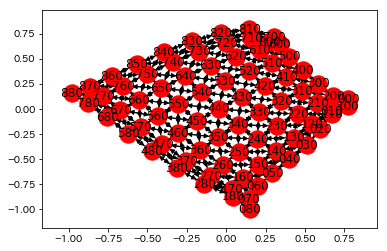

AtlasView({'550': {'people': 17, 'distance': 1.0}, '650': {'people': 19, 'distance': 1.414}, '640': {'people': 14, 'distance': 1.0}, '630': {'people': 6, 'distance': 1.414}, '530': {'people': 19, 'distance': 1.0}, '430': {'people': 0, 'distance': 1.414}, '440': {'people': 20, 'distance': 1.0}, '450': {'people': 16, 'distance': 1.414}})

In [14]:
n = network_array[people][ratio][seed]['census1']['3600'].copy()
nx.draw_networkx(n)
plt.show()
n['540']

In [15]:
import random

start_array = {}

for _times in env.TIMES_LIST():
    start_array[_times] = {}
    df = csv_array[people][ratio][seed]['mobile'][_times].copy()
    df['people'] = df['people']
    df = df[df['people'] != 0]

    stack_area = list(df['area'].values)
    stack_people = df['people'].sum()
    print(_times, ', stack: ', stack_people)

    for vehicle_id in range(stack_people):    
        random_area = random.choice(stack_area)
        df_choiced = df.loc[df['area'] == random_area, :]
        start_array[_times][vehicle_id] = df_choiced['area'].values[0]
        df.loc[df_choiced.index[0], 'people'] -= 1

        if df.loc[df_choiced.index[0], 'people'] == 0:
            stack_area.remove(random_area)
            df = df.drop(df_choiced.index[0])

3600 , stack:  305
7200 , stack:  655
10800 , stack:  698
14400 , stack:  667
18000 , stack:  501
21600 , stack:  267


In [16]:
305+655+698+667+501+267

3093

In [17]:
import math

# 7200から開始した時、3600mobileの人数+(7200mobileの人数-3600mobileの人数)をcensus1とcensus2の割合ごとに人数を分ける
# 0~3600, 3600~7200の後者を指定する
def calcurlate_stack(end_time):
#     end_time = '3600'
    times_list = env.TIMES_LIST()
    time_index = times_list.index(end_time)

    mobile_end = csv_array[people][ratio][seed]['mobile'][end_time]['people'].copy()
    mobile_start = pd.Series()
    if time_index != 0:
        mobile_start = csv_array[people][ratio][seed]['mobile'][times_list[time_index-1]]['people'].copy()

    census1 = csv_array[people][ratio][seed]['census1'][times_list[time_index]]['people'].copy()
    census2 = csv_array[people][ratio][seed]['census2'][times_list[time_index]]['people'].copy()

    census_sum = census1.sum() + census2.sum()
    mobile_diff = mobile_end.sum() - mobile_start.sum()

    # previousの人数計算
    # 継続人数を計算
    continue1 = math.modf(census1.sum() / census_sum * mobile_start.sum())
    continue2 = math.modf(census2.sum() / census_sum * mobile_start.sum())
    decimal = round(continue1[0]+continue2[0])
    continue1 = int(continue1[1])
    continue2 = int(continue2[1])
    if continue1 > continue2:
        continue1 += decimal
    else:
        continue2 += decimal

    # 差分==新しく出現 の人数を計算
    new1 = math.modf(census1.sum() / census_sum * mobile_diff)
    new2 = math.modf(census2.sum() / census_sum * mobile_diff)
    decimal = round(new1[0]+new2[0])
    new1 = int(new1[1])
    new2 = int(new2[1])
    if new1 > new2:
        new1 += decimal
    else:
        new2 += decimal

    print(mobile_start.sum(), ' : ',mobile_diff)
    print('census1: ', continue1, ', ', new1)
    print('census2: ', continue2, ', ', new2)
    
    return continue1+new1, continue2+new2

In [18]:
people1, people2 = calcurlate_stack('3600')

0.0  :  305.0
census1:  0 ,  107
census2:  0 ,  198


In [19]:
_times = '3600'
mobile = csv_array[people][ratio][seed]['mobile'][_times].copy()

# [census1 or 2][vehicle_id][[area1, area2, ...]]
vehicle_route_array = {}
# 経由ルートをスタックするので初期化
for _id, _start_area in start_array[_times].items():
    vehicle_route_array[_id] = []
    vehicle_route_array[_id].append(_start_area)
    #  初期位置を確保するために事前に-1
    mobile.loc[mobile['area'] == _start_area, 'people'] -= 1
    
start_census_array = {}
start_census_array['census1'] = dict(list(start_array[_times].items())[:people1])
start_census_array['census2'] = dict(list(start_array[_times].items())[people1:])

for _csv in ['census1', 'census2']:
    network = network_array[people][ratio][seed][_csv][_times].copy()
    
    for _id, _start_area in start_census_array[_csv].items():
        now_node = network[_start_area]
        now_node = dict(sorted(now_node.items(), key=lambda x: x[1]['distance']), reverse=(False if _csv == 'census1' else True))
        node_list = list(now_node.keys())
        next_area = node_list[0]
        next_node = network[next_area]
        
        route_length = random.randrange(20, 28)
        for _ in range(route_length):
            now_node = network[next_area]
            now_node = dict(sorted(now_node.items(), key=lambda x: x[1]['distance']), reverse=(False if _csv == 'census1' else True))
            node_list = list(now_node.keys())
            
            for _index, _around_area in enumerate(node_list):
                # 同じエリアには通らないようにする
                if _around_area in vehicle_route_array[_id]:
                    continue
                
                # 配列にルートを追加
                vehicle_route_array[_id].append(next_area)
                # 通ったエリアの人数を-1
                mobile.loc[mobile['area'] == next_area, 'people'] -= 1
                # 次のエリアを設定
                next_area = node_list[_index]
                next_node = network[next_area]
                # 次のエリアが一つ決まれば良いのでbreak
                break
        
        
        print('{}: id: {}, route: {}'.format(_csv, _id, vehicle_route_array[_id]))

census1: id: 0, route: ['630', '540', '550', '640', '530', '440', '450', '560', '650', '740', '750', '660', '760', '850', '840', '730', '620', '520', '430', '340', '350', '460', '360', '470', '570', '670', '770']
census1: id: 1, route: ['310', '420', '530', '540', '550', '640', '650', '740', '630', '520', '430', '440', '450', '560', '660', '750', '760', '850', '840', '730', '620', '720', '830', '820', '710', '610', '510']
census1: id: 2, route: ['420', '530', '540', '550', '640', '650', '740', '630', '520', '430', '440', '450', '560', '660', '750', '760', '850', '840', '730', '620', '720']
census1: id: 3, route: ['410', '520', '530', '540', '550', '640', '650', '740', '630', '730', '620', '720', '830', '840', '750', '660', '560', '450', '440', '430', '340', '350', '460', '360', '470', '570']
census1: id: 4, route: ['010', '120', '230', '340', '440', '540', '550', '640', '530', '630', '740', '650', '560', '450', '460', '350', '360', '470', '570', '660', '750', '760']
census1: id: 5, rou

census1: id: 41, route: ['510', '520', '530', '540', '550', '640', '650', '740', '630', '730', '620', '720', '830', '840', '750', '660', '560', '450', '440', '430', '340', '350', '460', '360']
census1: id: 42, route: ['520', '530', '540', '550', '640', '650', '740', '630', '730', '620', '720', '830', '840', '750', '660', '560', '450', '440', '430', '340', '350']
census1: id: 43, route: ['530', '540', '550', '640', '650', '740', '630', '520', '430', '440', '450', '560', '660', '750', '760', '850', '840', '730', '620', '720', '830', '820', '710', '610', '510', '420', '330', '340']
census1: id: 44, route: ['780', '670', '560', '550', '540', '640', '530', '440', '450', '340', '430', '520', '630', '740', '650', '660', '750', '760', '850', '840', '730', '620', '720']
census1: id: 45, route: ['400', '510', '520', '530', '540', '550', '640', '650', '740', '630', '730', '620', '720', '830', '840', '750', '660', '560', '450', '440', '430']
census1: id: 46, route: ['240', '340', '440', '540', '55

census1: id: 84, route: ['230', '340', '440', '540', '550', '640', '530', '630', '740', '650', '560', '450', '460', '350', '360', '470', '570', '660', '750', '760', '850', '840', '730', '620']
census1: id: 85, route: ['620', '530', '540', '550', '640', '650', '740', '630', '520', '430', '440', '450', '560', '660', '750', '760', '850', '840', '730', '720', '830', '820', '710', '610', '510', '420', '330']
census1: id: 86, route: ['730', '640', '540', '550', '440', '530', '630', '740', '650', '560', '450', '340', '430', '520', '620', '720', '830', '840', '750', '660', '760', '850', '860', '770', '670', '570']
census1: id: 87, route: ['640', '540', '550', '440', '530', '630', '740', '650', '560', '450', '340', '430', '520', '620', '730', '720', '830', '840', '750', '660', '760', '850', '860', '770', '670', '570', '460', '350']
census1: id: 88, route: ['210', '320', '430', '540', '550', '640', '530', '440', '450', '560', '650', '740', '630', '520', '620', '730', '720', '830', '840', '750', 

census2: id: 130, route: ['170', '260', '350', '440', '540', '550', '640', '530', '630', '740', '650', '560', '450', '340', '430', '520', '620', '730', '720', '830', '840']
census2: id: 131, route: ['860', '750', '640', '540', '550', '440', '530', '630', '740', '650', '560', '450', '340', '430', '520', '620', '730', '720', '830', '840', '850', '760']
census2: id: 132, route: ['210', '320', '430', '540', '550', '640', '530', '440', '450', '560', '650', '740', '630', '520', '620', '730', '720', '830', '840', '750', '660']
census2: id: 133, route: ['010', '120', '230', '340', '440', '540', '550', '640', '530', '630', '740', '650', '560', '450', '460', '350', '360', '470', '570', '660', '750', '760', '850', '840', '730', '620', '520']
census2: id: 134, route: ['010', '120', '230', '340', '440', '540', '550', '640', '530', '630', '740', '650', '560', '450', '460', '350', '360', '470', '570', '660', '750', '760', '850', '840', '730']
census2: id: 135, route: ['210', '320', '430', '540', '550

census2: id: 174, route: ['750', '640', '540', '550', '440', '530', '630', '740', '650', '560', '450', '340', '430', '520', '620', '730', '720', '830', '840', '850', '760']
census2: id: 175, route: ['410', '520', '530', '540', '550', '640', '650', '740', '630', '730', '620', '720', '830', '840', '750', '660', '560', '450', '440', '430', '340', '350']
census2: id: 176, route: ['210', '320', '430', '540', '550', '640', '530', '440', '450', '560', '650', '740', '630', '520', '620', '730', '720', '830', '840', '750', '660', '760']
census2: id: 177, route: ['640', '540', '550', '440', '530', '630', '740', '650', '560', '450', '340', '430', '520', '620', '730', '720', '830', '840', '750', '660', '760']
census2: id: 178, route: ['400', '510', '520', '530', '540', '550', '640', '650', '740', '630', '730', '620', '720', '830', '840', '750', '660', '560', '450', '440', '430', '340']
census2: id: 179, route: ['830', '740', '640', '540', '550', '440', '530', '630', '520', '430', '340', '450', '560

census2: id: 220, route: ['210', '320', '430', '540', '550', '640', '530', '440', '450', '560', '650', '740', '630', '520', '620', '730', '720', '830', '840', '750', '660', '760']
census2: id: 221, route: ['620', '530', '540', '550', '640', '650', '740', '630', '520', '430', '440', '450', '560', '660', '750', '760', '850', '840', '730', '720', '830', '820', '710']
census2: id: 222, route: ['210', '320', '430', '540', '550', '640', '530', '440', '450', '560', '650', '740', '630', '520', '620', '730', '720', '830', '840', '750', '660']
census2: id: 223, route: ['620', '530', '540', '550', '640', '650', '740', '630', '520', '430', '440', '450', '560', '660', '750', '760', '850', '840', '730', '720', '830', '820', '710', '610', '510', '420', '330']
census2: id: 224, route: ['540', '550', '640', '530', '440', '450', '560', '650', '740', '630', '520', '430', '340', '350', '460', '360', '470', '570', '660', '750', '760', '850']
census2: id: 225, route: ['210', '320', '430', '540', '550', '640

census2: id: 267, route: ['540', '550', '640', '530', '440', '450', '560', '650', '740', '630', '520', '430', '340', '350', '460', '360', '470', '570', '660', '750', '760', '850', '840', '730']
census2: id: 268, route: ['010', '120', '230', '340', '440', '540', '550', '640', '530', '630', '740', '650', '560', '450', '460', '350', '360', '470', '570', '660', '750', '760', '850', '840', '730', '620']
census2: id: 269, route: ['860', '750', '640', '540', '550', '440', '530', '630', '740', '650', '560', '450', '340', '430', '520', '620', '730', '720', '830', '840', '850', '760', '660', '570']
census2: id: 270, route: ['010', '120', '230', '340', '440', '540', '550', '640', '530', '630', '740', '650', '560', '450', '460', '350', '360', '470', '570', '660', '750', '760', '850', '840', '730', '620']
census2: id: 271, route: ['540', '550', '640', '530', '440', '450', '560', '650', '740', '630', '520', '430', '340', '350', '460', '360', '470', '570', '660', '750', '760', '850', '840', '730', '6

In [20]:
counter = 0
for _route in vehicle_route_array.values():
    counter += len(_route)

print(counter)

7397


In [21]:
print(csv_array[people][ratio][seed]['census1']['3600']['people'].sum())
print(csv_array[people][ratio][seed]['census2']['3600']['people'].sum())
print(csv_array[people][ratio][seed]['census1']['3600']['people'].sum()/people1)
print(csv_array[people][ratio][seed]['census2']['3600']['people'].sum()/people2)

521
962
4.869158878504673
4.858585858585859


In [22]:
people_sum = 0
for _times in env.TIMES_LIST():
    people_sum += csv_array[people][ratio][seed]['census'][_times]['people'].sum()
people_sum

16100

In [23]:
estimate_od = pd.DataFrame(columns=['id', 'csv'])

In [24]:
estimate_od = pd.DataFrame(list(vehicle_route_array.keys()), columns=['id'])
estimate_od['csv'] = estimate_od['id'].apply(lambda x: 'census1' if x < people1 else 'census2')
estimate_od = pd.concat([estimate_od, pd.DataFrame(list(vehicle_route_array.values()))], axis=1)
estimate_od.head()

,id,csv,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
0,0,census1,630,540,550,640,530,440,450,560,...,430,340,350,460,360,470,570,670,770,None
1,1,census1,310,420,530,540,550,640,650,740,...,840,730,620,720,830,820,710,610,510,None
2,2,census1,420,530,540,550,640,650,740,630,...,730,620,720,None,None,None,None,None,None,None
3,3,census1,410,520,530,540,550,640,650,740,...,440,430,340,350,460,360,470,570,None,None
4,4,census1,010,120,230,340,440,540,550,640,...,570,660,750,760,None,None,None,None,None,None


In [25]:
od_array = {}
def main(args, array):
    df = pd.read_csv(env.get_full_path('Origin', args),
                     names=env.get_col_names(),
                     encoding='Shift_JISx0213')
    array[args.dir][args.ratio][args.seed][args.csv] = df.copy()
        
env.for_default_init(main, od_array, ['od'])

In [26]:
od_array[people][ratio][seed]['od'].head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29
0,15131,Vehicle,FALSE,国道8号p(census)@389,国道8号o(census)@419,国道8号n(census)@503,石川県道198号a(census)@884,石川県道198号b(census)@887,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12929,Vehicle,FALSE,石川県道17号b(census)@430,石川県道8号l(census)@439,石川県道8号k(census)@543,石川県道8号j(census)@587,石川県道8号i(census)@722,石川県道291号b(census)@959,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15542,Vehicle,FALSE,石川県道196号k(census)@908,石川県道196号e(census)@1099,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19899,Vehicle,FALSE,石川県道8号s(census)@994,,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16531,Vehicle,FALSE,石川県道196号d(census)@753,国道8号h(census)@800,国道8号i(census)@858,国道8号j(census)@873,国道8号k(census)@952,国道8号l(census)@1008,国道8号m(census)@1043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
od_array[people][ratio][seed]['od'].shape

(2398, 30)